INTERFACE WITH GOOGLE DRIVE

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
uploaded = drive.CreateFile({'test': 'Sample.txt'})
uploaded.SetContentString('Sample upoad file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

#downloaded = drive.CreateFile({'id': uploaded.get('id')})
#print('Downloaded content"{}"'.format(downloaded.GetContentString()))

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
# listed = drive.ListFile({'q': "title contains '.txt' and 'root' in parents"}).GetList()
# for file in listed:
#   print('title {}, id {}'.format(file['title'], file['id']))

Uploaded file with ID 13K4g4LUKOmIr5fsJiWYVnUNPVfAm_T32


IMPORTS

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.axes import Axes as ax
import scipy
from PIL import Image
from scipy import ndimage
from scipy.misc import imsave
import tensorflow as tf
from tensorflow.python.framework import ops
from datetime import datetime
%matplotlib inline
#np.random.seed(1)

DATASET

In [0]:
 def load_dataset():
    from google.colab import files
    uploaded = files.upload()

    for name, data in uploaded.items():
      with open(name, 'wb') as f:
        f.write(data)
        print ('saved file', name)

    X_train = np.load('X_train.npy')
    Y_train = np.load('Y_train.npy')
    #X_dev   = np.load('X_dev.npy')
    #Y_dev   = np.load('Y_dev.npy')
    X_test  = np.load('X_test.npy')
    Y_test  = np.load('Y_test.npy')

    return X_train, Y_train, X_test, Y_test #, X_dev, Y_dev

In [4]:
X_train, Y_train, X_test, Y_test = load_dataset() #X_dev, Y_dev

Saving Y_train.npy to Y_train.npy
Saving Y_test.npy to Y_test.npy
Saving X_train.npy to X_train.npy
Saving X_test.npy to X_test.npy
saved file Y_train.npy
saved file Y_test.npy
saved file X_train.npy
saved file X_test.npy


PRINT OUT EXAMPLE IMAGE

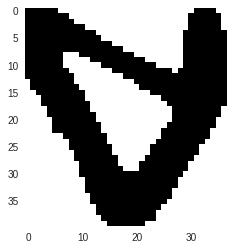

In [5]:
index = 312
example = Y_train[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

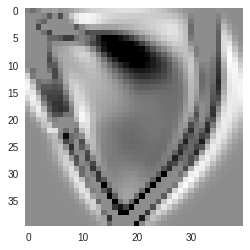

In [6]:
index = 312
example = X_train[index,:,:,1]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

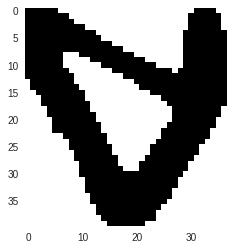

In [7]:
index = 312
example = Y_train[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

AUGMENT DATA

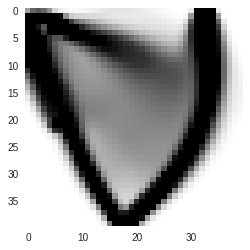

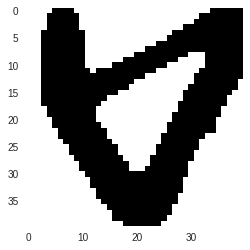

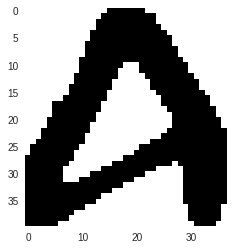

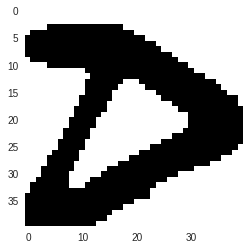

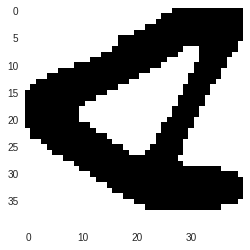

In [8]:
index = 312

example = X_train[index,:,:,0]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()


new_data_X_horiz = np.flip(X_train, axis = 2) # should be 1 and 2
new_data_Y_horiz = np.flip(Y_train, axis = 2)

new_data_X_vert = np.flip(X_train, axis = 1) # should be 1 and 2
new_data_Y_vert = np.flip(Y_train, axis = 1)

new_data_X_rotFor = np.rot90(X_train, k = 1, axes = (1,2)) # should be 1 and 2
new_data_Y_rotFor = np.rot90(Y_train, k = 1, axes = (1,2))

new_data_X_rotBack = np.rot90(X_train, k = 3, axes = (1,2)) # should be 1 and 2
new_data_Y_rotBack = np.rot90(Y_train, k = 3, axes = (1,2))

# CHECK
example = new_data_Y_horiz[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()
example = new_data_Y_vert[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

example = new_data_Y_rotFor[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

example = new_data_Y_rotBack[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()


X_train= np.concatenate((X_train, new_data_X_horiz, new_data_X_vert, new_data_X_rotFor, new_data_X_rotBack), axis = 0)
Y_train = np.concatenate((Y_train, new_data_Y_horiz, new_data_Y_vert, new_data_Y_rotFor, new_data_Y_rotBack), axis = 0)

In [9]:
print ("number of training examples = " + str(X_train.shape[0]))
#print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
#print ("X_dev shape: " + str(X_dev.shape))
#print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 40000
number of test examples = 1000
X_train shape: (40000, 40, 40, 2)
Y_train shape: (40000, 40, 40)
X_test shape: (1000, 40, 40, 2)
Y_test shape: (1000, 40, 40)


FRAMEWORK FUNCTIONS

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, n_C0], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [None, n_y], name = 'Y')
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    f1 = 16
    f2 = 32
    f3 = 64
    n_c = 2
    
    #tf.set_random_seed(1)

    W1 = tf.get_variable("W1", [3,3,n_c,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [3,3,f1,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W3 = tf.get_variable("W3", [3,3,f1,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W4 = tf.get_variable("W4", [3,3,f2,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W5 = tf.get_variable("W5", [3,3,f2,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W6 = tf.get_variable("W6", [3,3,f3,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W7 = tf.get_variable("W7", [3,3,f3,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W8 = tf.get_variable("W8", [3,3,f3,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W9 = tf.get_variable("W9", [3,3,f3+f2,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0)) ### 32
    W10 = tf.get_variable("W10", [3,3,f2,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W11 = tf.get_variable("W11", [3,3,f1+f2,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0)) ### 16
    W12 = tf.get_variable("W12", [3,3,f1,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    W13 = tf.get_variable("W13", [1,1,f1,1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2, "W3": W3, "W4": W4, "W5": W5, "W6": W6,
                  "W7": W7,"W8": W8, "W9": W9, "W10": W10,
                  "W11": W11,"W12": W12, "W13": W13
                  }
    
    return parameters

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 1):
    """
    Creates a list of random minibatches from (X, Y)
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples) mini_batch_size -- size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y) """
    
    np.random.seed(seed) 
    m = X.shape[0]
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m)) 
    shuffled_X = X[permutation,:,:,:]                     # [m,40,40,2]
    shuffled_Y = Y[permutation,:,:].reshape((m,40*40))    # [m,40*40]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    
    # MINIBATCH LOOP}
    for k in range(0, num_complete_minibatches):
      mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size,:,:] #[64,40,40]
      mini_batch_X = mini_batch_X.reshape((mini_batch_size, shuffled_X.shape[1], shuffled_X.shape[2],shuffled_X.shape[3]))
      
      mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size,:]  #[m,1600]

      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)      

    # END CASE (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
      mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:m,:,:] 
      mini_batch_X = mini_batch_X.reshape(((m-mini_batch_size*(m%mini_batch_size)), shuffled_X.shape[1], shuffled_X.shape[2],shuffled_X.shape[3]))
      
      mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:m,:]
      
      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)
    
    return mini_batches
  
def forward_propagation(X, parameters, phase):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    W6 = parameters['W6']
    W7 = parameters['W7']
    W8 = parameters['W8']
    W9 = parameters['W9']
    W10 = parameters['W10']
    W11 = parameters['W11']
    W12 = parameters['W12']
    W13 = parameters['W13']
    
    keep_probability = 0.5
    bn = True
    
    #### BLOCK 1 (16 channels) ####
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B1 = tf.contrib.layers.batch_norm(Z1, center = True, scale = True, is_training = phase)
        Z1 = B1
    # RELU
    A1 = tf.nn.relu(Z1)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z2 = tf.nn.conv2d(A1, W2, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B2 = tf.contrib.layers.batch_norm(Z2, center = True, scale = True, is_training = phase)
        Z2 = B2
    # RELU
    A2 = tf.nn.relu(Z2) 
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    
    #### BLOCK 2 (32 channels) ####
    # CONV2D: stride of 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P1, W3, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B3 = tf.contrib.layers.batch_norm(Z3, center = True, scale = True, is_training = phase)
        Z3 = B3
    # RELU
    A3 = tf.nn.relu(Z3)
    
    # DROPOUT
    D1 = tf.nn.dropout(A3, keep_prob = keep_probability)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z4 = tf.nn.conv2d(D1, W4, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B4 = tf.contrib.layers.batch_norm(Z4, center = True, scale = True, is_training = phase)
        Z4 = B4
    # RELU
    A4 = tf.nn.relu(Z4)
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P2 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    
    #### BLOCK 3 (64 channels) ####
    # CONV2D: stride of 1, padding 'SAME'
    Z5 = tf.nn.conv2d(P2, W5, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B5 = tf.contrib.layers.batch_norm(Z5, center = True, scale = True, is_training = phase)
        Z5 = B5
    # RELU
    A5 = tf.nn.relu(Z5)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z6 = tf.nn.conv2d(A5, W6, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B6 = tf.contrib.layers.batch_norm(Z6, center = True, scale = True, is_training = phase)
        Z6 = B6
    # RELU
    A6 = tf.nn.relu(Z6)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z7 = tf.nn.conv2d(A6, W7, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B7 = tf.contrib.layers.batch_norm(Z7, center = True, scale = True, is_training = phase)
        Z7 = B7
    # RELU
    A7 = tf.nn.relu(Z7)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z8 = tf.nn.conv2d(A7, W8, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B8 = tf.contrib.layers.batch_norm(Z8, center = True, scale = True, is_training = phase)
        Z8 = B8
    # RELU
    A8 = tf.nn.relu(Z8)
    
    #### BLOCK 4 (32 channels) ####
    # UPSAMPLE
    U1 = tf.keras.layers.UpSampling2D((2,2))(A8)
    # CONCATENATE
    C1 = tf.concat([U1,A4], axis = 3)  # should have 64 channels - need to convolve down to 32
    # CONV2D: stride of 1, padding 'SAME'
    Z9 = tf.nn.conv2d(C1, W9, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B9 = tf.contrib.layers.batch_norm(Z9, center = True, scale = True, is_training = phase)
        Z9 = B9
    # RELU
    A9 = tf.nn.relu(Z9)
    # DROPOUT
    D2 = tf.nn.dropout(A9, keep_prob = keep_probability)

    # CONV2D: stride of 1, padding 'SAME'
    Z10 = tf.nn.conv2d(D2, W10, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B10 = tf.contrib.layers.batch_norm(Z10, center = True, scale = True, is_training = phase)
        Z10 = B10
    # RELU
    A10 = tf.nn.relu(Z10)
    
    #### BLOCK 5 (16 channels) ####
    # UPSAMPLE
    U2 = tf.keras.layers.UpSampling2D((2,2))(A10)
    # CONCATENATE
    C2 = tf.concat([U2,A2], axis = 3) # should have 32 channels - need to convolve down to 16 #contrib.keras.layers.concatenate
    # CONV2D: stride of 1, padding 'SAME'
    Z11 = tf.nn.conv2d(C2, W11, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B11 = tf.contrib.layers.batch_norm(Z11, center = True, scale = True, is_training = phase)
        Z11 = B11
    # RELU
    A11 = tf.nn.relu(Z11)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z12 = tf.nn.conv2d(A11, W12, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B12 = tf.contrib.layers.batch_norm(Z12, center = True, scale = True, is_training = phase)
        Z12 = B12
    # RELU
    A12 = tf.nn.relu(Z12)
    
    # FLATTEN
    Z13 = tf.nn.conv2d(A12, W13, strides = [1,1,1,1], padding = 'SAME')
    F1 = tf.contrib.layers.flatten(Z13)
    Z14 = tf.contrib.layers.fully_connected(F1, num_outputs = 40*40, activation_fn = None) #tf.nn.sigmoid   
    
    return Z14

def compute_cost(Z, Y):
    """
    Computes the cost

    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (40*40, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z

    Returns:
    cost - Tensor of the cost function
    """
    
    my_logits=tf.reshape(Z, (-1,1))
    my_labels=tf.reshape(Y, (-1,1))
    binary_labels = tf.nn.sigmoid(my_logits) > 0.5
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=my_logits, labels=my_labels))
    mean_IOU = tf.metrics.mean_iou(labels = my_labels, predictions = binary_labels, num_classes = 2)
    accuracy = tf.metrics.accuracy(labels = my_labels, predictions = binary_labels)
    
    return cost, mean_IOU, accuracy


In [0]:
def print_topology(data):
    """
    Arguments:
      data -- image of size (40,40,1)
    Returns:
      nothing
    """
    fig = plt.figure()
    plt.grid(False)
    plt.imshow(data[:,:,0], cmap="binary")
    plt.show()

    return

RUN MODEL

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 40, 40, 1)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 40, 40, 1)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                          # to be able to rerun the model without overwriting tf variables
    #tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 18#3                                        # to keep results consistent (numpy seed)
    
    (m, n_H0, n_W0, n_C0) = X_train.shape
    print(m)
    n_y = Y_train.shape[1]*Y_train.shape[2]                            
    
    minibatch_costs = []
    costs = []
    costs_dev = []
    IOU = []
    IOU_dev = []
    acc = []
    acc_dev = []
    
    number = 25
    

    X_dev = X_test
    #X_dev = X_dev.reshape((X_dev.shape[0], X_dev.shape[1], X_dev.shape[2],2))
    Y_dev = Y_test
    
    # RESHAPE INPUTS
    Y_dev = Y_dev.reshape((Y_dev.shape[0], Y_dev.shape[1]*Y_dev.shape[2]))
    
    # PLACEHOLDERS
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    phase = tf.placeholder(tf.bool)

    # INITIALIZE PARAMETERS
    parameters = initialize_parameters()
    
    # FORWARD PROPAGATION
    Z = forward_propagation(X, parameters, phase)
    
    # COST FUNCTION
    cost, mean_IOU, accuracy = compute_cost(Z, Y)
    
    # BACKPROPAGATION
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # INITIALIZE ALL VARIABLES GLOBALLY AND LOCALLY
    init = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    # ENCODE IMAGE
    image = tf.reshape(tf.image.convert_image_dtype(Z[number,:], tf.int64), [40, 40,1])

    # START TENSORFLOW SESSION
    with tf.Session() as sess:
        
        # SESSION INITIALIZATION
        sess.run(init)
        sess.run(init_local)
        
        # TRAINING LOOP
        for epoch in range(num_epochs):
            print(epoch)
            
            minibatch_cost = 0.
            minibatch_IOU = 0.
            minibatch_acc = 0.

            num_minibatches = int(m / minibatch_size)
          
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            # MINIBATCH LOOP
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost, image_enc, params, IOU_current, accuracy_current = sess.run([optimizer, cost, image, parameters, mean_IOU, accuracy], feed_dict={X: minibatch_X, Y: minibatch_Y, phase: True})
                
                minibatch_cost += temp_cost / num_minibatches
                minibatch_IOU += IOU_current[0] / num_minibatches
                minibatch_acc += accuracy_current[0]/ num_minibatches
                minibatch_costs.append(temp_cost)

            # CALCULATE DEV SET COST + IOU EACH EPOCH
            temp_cost_dev, temp_IOU_dev, temp_acc_dev, image_enc_test = sess.run([cost, mean_IOU, accuracy, image], feed_dict = {X:X_dev, Y:Y_dev, phase: False})

            # PRINT COST EVERY 5 EPOCHS
            if print_cost == True and epoch == 0:
                print_topology(X_dev[number,:,:,:])
                print_topology(np.reshape(Y_dev[number,:], (40, 40,1)))
                
            if print_cost == True and epoch % 5 == 0:
                print_topology(image_enc_test)
                print ("TRAIN COST @ EPOCH %i: %f" % (epoch, minibatch_cost))
                print ("TRAIN IOU  @ EPOCH %i: %f" % (epoch, minibatch_IOU))
                print ("TRAIN ACC  @ EPOCH %i: %f" % (epoch, minibatch_acc))
                print ("TEST  COST @ EPOCH %i: %f" % (epoch, temp_cost_dev))
                print ("TEST  IOU  @ EPOCH %i: %f" % (epoch, temp_IOU_dev[0]))
                print ("TEST  ACC  @ EPOCH %i: %f" % (epoch, temp_acc_dev[0]))
                
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                IOU.append(minibatch_IOU)
                acc.append(minibatch_acc)
                costs_dev.append(temp_cost_dev)
                IOU_dev.append(temp_IOU_dev[0])
                acc_dev.append(temp_acc_dev[0])
        
        # PLOT TRAIN COST, IOU, AND ACC
        plt.plot(np.squeeze(costs), 'b', np.squeeze(costs_dev), 'g') #, np.squeeze(minibatch_costs), 'r'
        plt.ylabel('COST')
        plt.xlabel('iterations (per tens)')
        plt.title("COST (TRAIN SET) (Learning rate =" + str(learning_rate) + ")")
        plt.show()

#         plt.plot( np.squeeze(costs_dev), 'g') #np.squeeze(costs), 'b',
#         plt.ylabel('COST')
#         plt.xlabel('iterations (per tens)')
#         plt.title("COST (TRAIN SET) (Learning rate =" + str(learning_rate) + ")")
#         plt.show()
#         plt.plot(np.squeeze(minibatch_costs), 'r') #np.squeeze(costs), 'b',
#         plt.ylabel('COST')
#         plt.xlabel('iterations (per tens)')
#         plt.title("COST (TRAIN SET) (Learning rate =" + str(learning_rate) + ")")
#         plt.show()
        
        plt.plot(np.squeeze(IOU), 'b', np.squeeze(IOU_dev), 'g')
        plt.ylabel('IOU')
        plt.xlabel('iterations (per tens)')
        plt.title("IOU (TRAIN_SET)")
        plt.show()
        
        plt.plot(np.squeeze(acc), 'b', np.squeeze(acc_dev), 'g')
        plt.ylabel('ACC')
        plt.xlabel('iterations (per tens)')
        plt.title("ACC (TRAIN_SET)")
        plt.show()

        print_topology(np.reshape(Y_dev[number,:], (40, 40,1)))
        print_topology(image_enc_test)
  
        # PLOT DEV COST, IOU, AND ACC
#         plt.plot(np.squeeze(costs_dev))
#         plt.ylabel('COST')
#         plt.xlabel('iterations (per tens)')
#         plt.title("COST (DEV SET) (Learning rate =" + str(learning_rate) + ")")
#         plt.show()

#         plt.plot(np.squeeze(IOU_dev))
#         plt.ylabel('IOU')
#         plt.xlabel('iterations (per tens)')
#         plt.title("IOU (DEV SET)")
#         plt.show()
        
#         plt.plot(np.squeeze(acc_dev))
#         plt.ylabel('ACC')
#         plt.xlabel('iterations (per tens)')
#         plt.title("ACC (DEV_SET)")
#         plt.show()
        
                
        return parameters, costs, IOU, acc, costs_dev, IOU_dev, acc_dev

40000
0


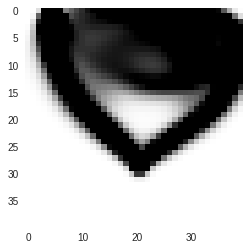

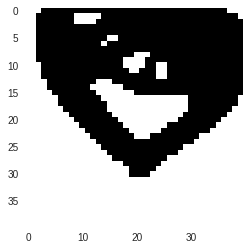

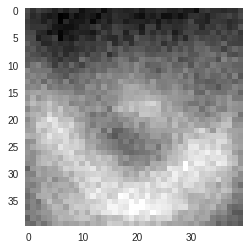

TRAIN COST @ EPOCH 0: 0.291573
TRAIN IOU  @ EPOCH 0: 0.631687
TRAIN ACC  @ EPOCH 0: 0.767362
TEST  COST @ EPOCH 0: 0.615203
TEST  IOU  @ EPOCH 0: 0.751081
TEST  ACC  @ EPOCH 0: 0.857854
1
2
3
4
5


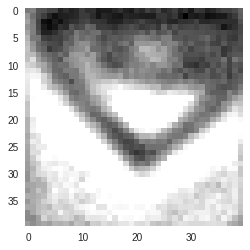

TRAIN COST @ EPOCH 5: 0.117123
TRAIN IOU  @ EPOCH 5: 0.852285
TRAIN ACC  @ EPOCH 5: 0.920280
TEST  COST @ EPOCH 5: 0.531255
TEST  IOU  @ EPOCH 5: 0.856440
TEST  ACC  @ EPOCH 5: 0.922698
6
7
8
9
10


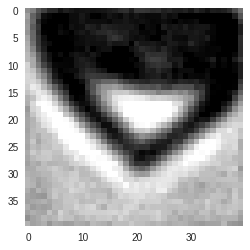

TRAIN COST @ EPOCH 10: 0.106253
TRAIN IOU  @ EPOCH 10: 0.877008
TRAIN ACC  @ EPOCH 10: 0.934495
TEST  COST @ EPOCH 10: 0.469534
TEST  IOU  @ EPOCH 10: 0.878551
TEST  ACC  @ EPOCH 10: 0.935369
11
12
13
14
15


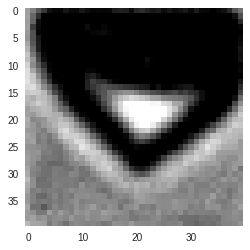

TRAIN COST @ EPOCH 15: 0.100544
TRAIN IOU  @ EPOCH 15: 0.887960
TRAIN ACC  @ EPOCH 15: 0.940671
TEST  COST @ EPOCH 15: 0.489393
TEST  IOU  @ EPOCH 15: 0.888815
TEST  ACC  @ EPOCH 15: 0.941151
16
17
18
19
20


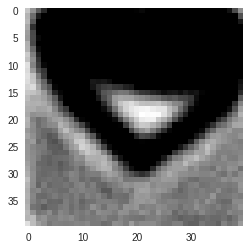

TRAIN COST @ EPOCH 20: 0.096823
TRAIN IOU  @ EPOCH 20: 0.892860
TRAIN ACC  @ EPOCH 20: 0.943409
TEST  COST @ EPOCH 20: 0.512278
TEST  IOU  @ EPOCH 20: 0.893472
TEST  ACC  @ EPOCH 20: 0.943750
21
22
23
24
25


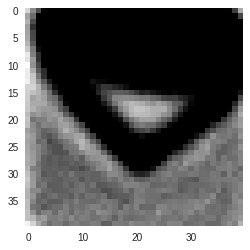

TRAIN COST @ EPOCH 25: 0.094016
TRAIN IOU  @ EPOCH 25: 0.895487
TRAIN ACC  @ EPOCH 25: 0.944872
TEST  COST @ EPOCH 25: 0.530037
TEST  IOU  @ EPOCH 25: 0.895978
TEST  ACC  @ EPOCH 25: 0.945145
26
27
28
29
30


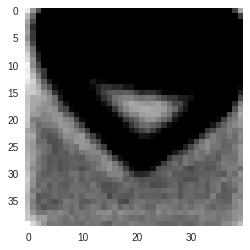

TRAIN COST @ EPOCH 30: 0.091648
TRAIN IOU  @ EPOCH 30: 0.897127
TRAIN ACC  @ EPOCH 30: 0.945782
TEST  COST @ EPOCH 30: 0.543915
TEST  IOU  @ EPOCH 30: 0.897542
TEST  ACC  @ EPOCH 30: 0.946012
31
32
33
34
35


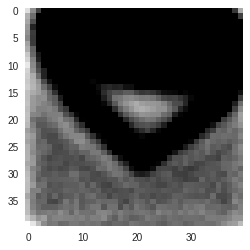

TRAIN COST @ EPOCH 35: 0.089618
TRAIN IOU  @ EPOCH 35: 0.898482
TRAIN ACC  @ EPOCH 35: 0.946532
TEST  COST @ EPOCH 35: 0.552737
TEST  IOU  @ EPOCH 35: 0.898840
TEST  ACC  @ EPOCH 35: 0.946731
36
37
38
39
40


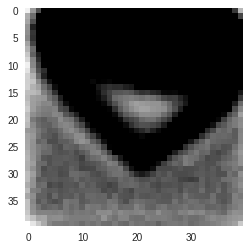

TRAIN COST @ EPOCH 40: 0.087827
TRAIN IOU  @ EPOCH 40: 0.899644
TRAIN ACC  @ EPOCH 40: 0.947179
TEST  COST @ EPOCH 40: 0.549815
TEST  IOU  @ EPOCH 40: 0.899964
TEST  ACC  @ EPOCH 40: 0.947356
41
42
43
44
45


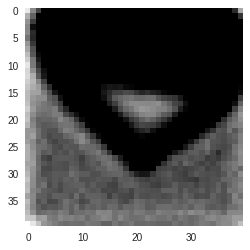

TRAIN COST @ EPOCH 45: 0.086187
TRAIN IOU  @ EPOCH 45: 0.900739
TRAIN ACC  @ EPOCH 45: 0.947784
TEST  COST @ EPOCH 45: 0.554825
TEST  IOU  @ EPOCH 45: 0.901027
TEST  ACC  @ EPOCH 45: 0.947944
46
47
48
49
50


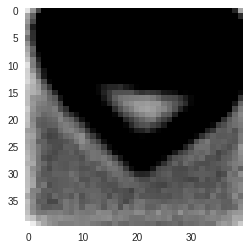

TRAIN COST @ EPOCH 50: 0.084684
TRAIN IOU  @ EPOCH 50: 0.901736
TRAIN ACC  @ EPOCH 50: 0.948337
TEST  COST @ EPOCH 50: 0.547650
TEST  IOU  @ EPOCH 50: 0.901998
TEST  ACC  @ EPOCH 50: 0.948482
51
52
53
54
55


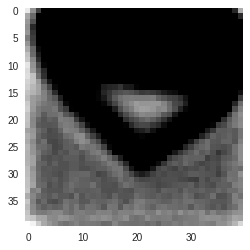

TRAIN COST @ EPOCH 55: 0.083258
TRAIN IOU  @ EPOCH 55: 0.902681
TRAIN ACC  @ EPOCH 55: 0.948858
TEST  COST @ EPOCH 55: 0.549251
TEST  IOU  @ EPOCH 55: 0.902923
TEST  ACC  @ EPOCH 55: 0.948993
56
57
58
59
60


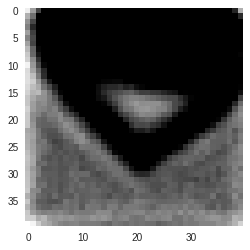

TRAIN COST @ EPOCH 60: 0.081827
TRAIN IOU  @ EPOCH 60: 0.903588
TRAIN ACC  @ EPOCH 60: 0.949362
TEST  COST @ EPOCH 60: 0.546918
TEST  IOU  @ EPOCH 60: 0.903810
TEST  ACC  @ EPOCH 60: 0.949484
61
62
63
64
65


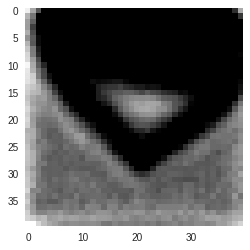

TRAIN COST @ EPOCH 65: 0.080414
TRAIN IOU  @ EPOCH 65: 0.904467
TRAIN ACC  @ EPOCH 65: 0.949845
TEST  COST @ EPOCH 65: 0.535735
TEST  IOU  @ EPOCH 65: 0.904676
TEST  ACC  @ EPOCH 65: 0.949960
66
67
68
69
70


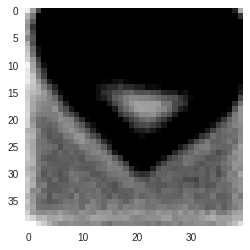

TRAIN COST @ EPOCH 70: 0.079133
TRAIN IOU  @ EPOCH 70: 0.905385
TRAIN ACC  @ EPOCH 70: 0.950351
TEST  COST @ EPOCH 70: 0.536570
TEST  IOU  @ EPOCH 70: 0.905580
TEST  ACC  @ EPOCH 70: 0.950458
71
72
73
74
75


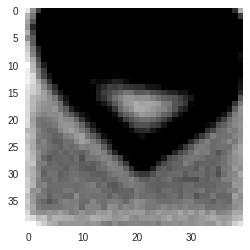

TRAIN COST @ EPOCH 75: 0.077715
TRAIN IOU  @ EPOCH 75: 0.906310
TRAIN ACC  @ EPOCH 75: 0.950861
TEST  COST @ EPOCH 75: 0.526780
TEST  IOU  @ EPOCH 75: 0.906494
TEST  ACC  @ EPOCH 75: 0.950963
76
77
78
79
80


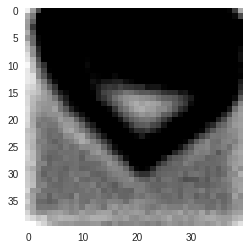

TRAIN COST @ EPOCH 80: 0.076362
TRAIN IOU  @ EPOCH 80: 0.907253
TRAIN ACC  @ EPOCH 80: 0.951377
TEST  COST @ EPOCH 80: 0.522892
TEST  IOU  @ EPOCH 80: 0.907429
TEST  ACC  @ EPOCH 80: 0.951473
81
82
83
84
85


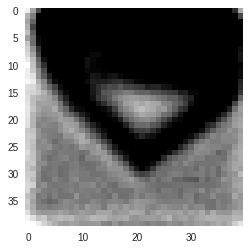

TRAIN COST @ EPOCH 85: 0.074826
TRAIN IOU  @ EPOCH 85: 0.908230
TRAIN ACC  @ EPOCH 85: 0.951914
TEST  COST @ EPOCH 85: 0.515332
TEST  IOU  @ EPOCH 85: 0.908394
TEST  ACC  @ EPOCH 85: 0.952004
86
87
88
89
90


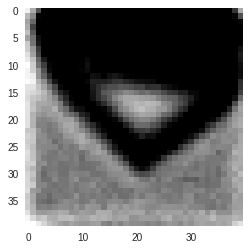

TRAIN COST @ EPOCH 90: 0.073261
TRAIN IOU  @ EPOCH 90: 0.909251
TRAIN ACC  @ EPOCH 90: 0.952472
TEST  COST @ EPOCH 90: 0.511218
TEST  IOU  @ EPOCH 90: 0.909410
TEST  ACC  @ EPOCH 90: 0.952560
91
92
93
94
95


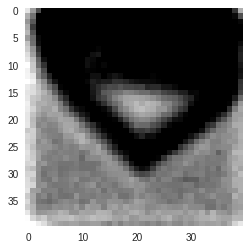

TRAIN COST @ EPOCH 95: 0.071780
TRAIN IOU  @ EPOCH 95: 0.910292
TRAIN ACC  @ EPOCH 95: 0.953043
TEST  COST @ EPOCH 95: 0.508327
TEST  IOU  @ EPOCH 95: 0.910443
TEST  ACC  @ EPOCH 95: 0.953127
96
97
98
99


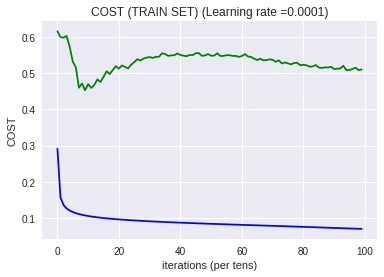

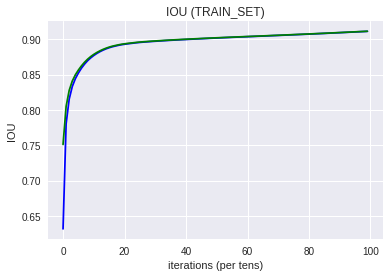

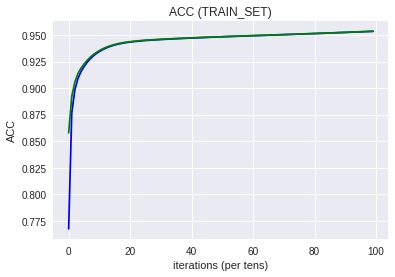

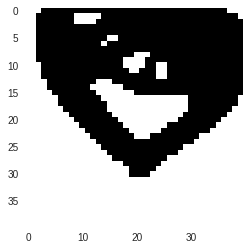

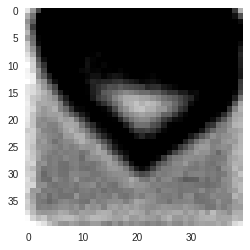

({'W1': <tf.Variable 'W1:0' shape=(3, 3, 2, 16) dtype=float32_ref>,
  'W10': <tf.Variable 'W10:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
  'W11': <tf.Variable 'W11:0' shape=(3, 3, 48, 16) dtype=float32_ref>,
  'W12': <tf.Variable 'W12:0' shape=(3, 3, 16, 16) dtype=float32_ref>,
  'W13': <tf.Variable 'W13:0' shape=(1, 1, 16, 1) dtype=float32_ref>,
  'W2': <tf.Variable 'W2:0' shape=(3, 3, 16, 16) dtype=float32_ref>,
  'W3': <tf.Variable 'W3:0' shape=(3, 3, 16, 32) dtype=float32_ref>,
  'W4': <tf.Variable 'W4:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
  'W5': <tf.Variable 'W5:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
  'W6': <tf.Variable 'W6:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
  'W7': <tf.Variable 'W7:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
  'W8': <tf.Variable 'W8:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
  'W9': <tf.Variable 'W9:0' shape=(3, 3, 96, 32) dtype=float32_ref>},
 [0.29157278501987444,
  0.15693128937482845,
  0.13647118648290635,
  0.12689105728864666,
  0.

In [15]:
model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 100, minibatch_size = 64, print_cost = True)